In [4]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss
import matplotlib.pyplot as plt


In [5]:
def sigmoid(x, derivative = False):
    val = 1/(1 + np.exp(-x))
    if(derivative):
        return val * (1 - val)
    else:
        return val
    
def tanh(x, derivative = False):
    val = np.tanh(x)
    if derivative:
        return 1 - val**2
    else:
        return val
    
def relu(x, derivative = False):
    if derivative:
        return np.where(x > 0, 1, 0)
    return np.maximum(0,x)

def binary_cross_entropy_loss(y_pred, y_true):
    return -np.mean(y_true * np.log(y_pred + 1e-9) + (1 - y_true) * np.log(1 - y_pred + 1e-9))


In [6]:
def train_sgd(model, X, y, learning_rate):
        m = X.shape[0]
        indices = np.random.permutation(m)
        total_loss = 0

        for i in indices:
            X_batch = X[i:i+1]
            y_batch = y[i:i+1]
            total_loss += train_step(model, X_batch, y_batch, learning_rate)

        return total_loss/m

def train_minibatch(model, X, y, learning_rate, batch_size):
        """ Mini-batch Gradient Descent: Updates weights after each mini-batch """
        m = X.shape[0]
        indices = np.random.permutation(m)

        X_shuffled = X[indices]
        y_shuffled = y[indices]

        total_loss = 0
        num_batches = 0

        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            total_loss += train_step(model, X_batch, y_batch, learning_rate)  # Use returned loss
            num_batches += 1

        return total_loss / num_batches

def train_batch(model, X, y, learning_rate):
        m = X.shape[0]
        indices = np.random.permutation(m)

        X_shuffled = X[indices]
        y_shuffled = y[indices]
        return train_step(model, X_shuffled, y_shuffled, learning_rate)

def train_step(model, X_batch, y_batch, learning_rate):
        """ Performs forward, backward pass and updates weights """
        y_pred = model.forward(X_batch)
        loss = binary_cross_entropy_loss(y_pred, y_batch)
        grads_w, grads_b = model.backward(X_batch, y_batch)

        for i in range(len(model.weights)):
            model.weights[i] -= learning_rate * grads_w[i]
            model.biases[i] -= learning_rate * grads_b[i]

        return loss

In [22]:
class MLP:
    def __init__(self, input_size, hidden_layers, output_size, activation='relu', optimizer='batchgd', learning_rate=0.01, batch_size=None):
        self.layers = [input_size] + hidden_layers + [output_size]
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.weights = []
        self.biases = []
        self.losses = []

        for i in range(len(self.layers) - 1):
            layer_input_size = self.layers[i]
            layer_output_size = self.layers[i + 1]
            
            weight_matrix = np.random.randn(layer_input_size, layer_output_size) * 0.1
            bias = np.zeros((1, layer_output_size))
            
            self.weights.append(weight_matrix)
            self.biases.append(bias)

        activation_funs = {'sigmoid': sigmoid, 'tanh': tanh, 'relu': relu}
        self.activation = activation_funs[activation]

        self.learning_rate = learning_rate

    def forward(self, X):
        self.a = []
        self.a.append(X)
        self.z_values = []

        
        for i in range(len(self.weights)):
            W = self.weights[i]
            b = self.biases[i]
            prev_a = self.a[-1]
            
            z = np.dot(prev_a, W) + b
            self.z_values.append(z)

            if i < len(self.weights) - 1:
                activation_output = self.activation(z)
            else:
                activation_output = sigmoid(z)
            
            self.a.append(activation_output)

        return self.a[-1]

    def backward(self, X, y):
        m = X.shape[0]

        grads_w = [np.zeros_like(w) for w in self.weights]
        grads_b = [np.zeros_like(b) for b in self.biases]

        dz = self.a[-1] - y

        for i in reversed(range(len(self.weights))):
            W = self.weights[i]
            a_prev = self.a[i]

            dw = np.dot(a_prev.T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m

            grads_w[i] = dw
            grads_b[i] = db

            if i > 0:
                dz = np.dot(dz, W.T) * self.activation(self.z_values[i-1], derivative=True)

        return grads_w, grads_b
    
    def train(self, X, y, epochs=100):
        for epoch in range(epochs):
            if self.optimizer == 'sgd':
                # print("sgd")
                loss_val = train_sgd(self, X, y, self.learning_rate)
            elif self.optimizer == 'minibatchgd':
                # print("mini")
                loss_val = train_minibatch(self, X, y, self.learning_rate, self.batch_size)
            elif self.optimizer == 'batchgd':
                # print("whole")
                loss_val = train_batch(self, X, y, self.learning_rate)
            self.losses.append(loss_val)
            # print(f'Epoch {epoch}, Loss: {loss_val:.4f}')

        plt.plot(range(1, epochs+1), self.losses, marker='o', linestyle='-')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Epoch vs Loss")
        plt.grid()
        plt.show()

In [8]:
def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

def compute_tf(tokens, vocab, word_to_index):
    token_counts = Counter(tokens)
    tf_vector = np.zeros(len(vocab))
    for word, count in token_counts.items():
        if word in word_to_index:
            tf_vector[word_to_index[word]] = count / len(tokens)
    return tf_vector

In [9]:
def test_model(model, test_csv, idf, mlb, vocab, word_to_index):
    df_test = pd.read_csv(test_csv, encoding="utf-8")

    df_test = df_test.dropna(subset=["document", "category"])

    df_test["document"] = df_test["document"].astype(str).str.strip()
    df_test["category"] = df_test["category"].astype(str).str.strip()

    # Convert categories into lists (already correct)
    df_test["category"] = df_test["category"].apply(lambda x: x.split(","))

    df_test["tokens"] = df_test["document"].apply(tokenize)

    tf_test_matrix = np.array([compute_tf(tokens, vocab, word_to_index) for tokens in df_test["tokens"]])

    tfidf_test_matrix = tf_test_matrix * idf  

    # Fix: Don't apply split, categories are already lists
    y_test_binary = mlb.transform(df_test["category"])

    # Model predictions (assuming sigmoid activation, threshold at 0.5 for multilabel classification)
    y_pred_proba = model.forward(tfidf_test_matrix)
    y_pred_binary = (y_pred_proba >= 0.5).astype(int)

    # **Calculate Accuracy & Hamming Loss**
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    hamming = hamming_loss(y_test_binary, y_pred_binary)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Hamming Loss for test: {hamming:.4f}")

In [10]:
def test_model_for_val(model, X_val, y_val):
    y_pred_proba = model.forward(X_val)
    y_pred_binary = (y_pred_proba >= 0.5).astype(int)

    # **Calculate Accuracy & Hamming Loss**
    accuracy = accuracy_score(y_val, y_pred_binary)
    hamming = hamming_loss(y_val, y_pred_binary)

    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Hamming Loss for validation: {hamming:.4f}")    


In [11]:
def preprocessing_train():
    df = pd.read_csv("train.csv", encoding="utf-8")

    df = df.dropna(subset=["document", "category"])

    # Convert to string and strip whitespace
    df["document"] = df["document"].astype(str).str.strip()
    df["category"] = df["category"].astype(str).str.strip()

    df["category"] = df["category"].apply(lambda x: x.split(","))

    df["tokens"] = df["document"].apply(tokenize)

    word_counts = Counter(word for tokens in df["tokens"] for word in tokens)

    vocab = [word for word, _ in word_counts.most_common(5000)]
    word_to_index = {word: i for i, word in enumerate(vocab)}

    tf_matrix = np.array([compute_tf(tokens, vocab, word_to_index) for tokens in df["tokens"]])

    doc_count = np.zeros(len(vocab))
    for tokens in df["tokens"]:
        unique_words = set(tokens)
        for word in unique_words:
            if word in word_to_index:
                doc_count[word_to_index[word]] += 1

    idf = np.log((1 + len(df)) / (1 + doc_count)) + 1

    tfidf_train_matrix = tf_matrix * idf

    mlb = MultiLabelBinarizer()
    y_binary = mlb.fit_transform(df["category"])

    X_train, X_val, y_train, y_val = train_test_split(tfidf_train_matrix, y_binary, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val, idf, mlb, vocab, word_to_index


In [12]:
X_train, X_val, y_train, y_val, idf, mlb, vocab, word_to_index = preprocessing_train()

In [14]:
def mlp_executive(epochs, hidden_layers_list, activation, optimizer, learning_rate, batch_size):
    np.random.seed(42)
    
    model = MLP(input_size=X_train.shape[1], hidden_layers=hidden_layers_list, output_size=y_train.shape[1], activation=activation, optimizer=optimizer, learning_rate=learning_rate, batch_size=batch_size)
    model.train(X_train, y_train, epochs=epochs)
    test_model_for_val(model, X_val, y_val)
    test_model(model, "test.csv", idf, mlb, vocab, word_to_index)


In [18]:
epochs = [5, 10, 20, 40]
for i in epochs:
    print(f"The epoch value is {i}")
    mlp_executive(i, [512, 256], "relu", "minibatchgd", 0.01, 64)

The epoch value is 5
Validation Accuracy: 0.1782
Hamming Loss for validation: 0.0117
Test Accuracy: 0.2219
Hamming Loss for test: 0.0113
The epoch value is 10
Validation Accuracy: 0.3391
Hamming Loss for validation: 0.0112
Test Accuracy: 0.3485
Hamming Loss for test: 0.0112
The epoch value is 20
Validation Accuracy: 0.3468
Hamming Loss for validation: 0.0100
Test Accuracy: 0.3594
Hamming Loss for test: 0.0099
The epoch value is 40
Validation Accuracy: 0.5135
Hamming Loss for validation: 0.0082
Test Accuracy: 0.5552
Hamming Loss for test: 0.0078


In [13]:
hidden_layers = [[10, 10], [256, 32], [512, 256], [512, 256, 256]]
for i in hidden_layers:
    print(f"The epoch value is {i}")
    mlp_executive(20, i, "relu", "minibatchgd", 0.01, 64)

The epoch value is [10, 10]
Validation Accuracy: 0.0000
Hamming Loss for validation: 0.0137
Test Accuracy: 0.0000
Hamming Loss for test: 0.0138
The epoch value is [256, 32]
Validation Accuracy: 0.2613
Hamming Loss for validation: 0.0108
Test Accuracy: 0.3018
Hamming Loss for test: 0.0104
The epoch value is [512, 256]
Validation Accuracy: 0.3468
Hamming Loss for validation: 0.0100
Test Accuracy: 0.3594
Hamming Loss for test: 0.0099
The epoch value is [512, 256, 256]
Validation Accuracy: 0.4492
Hamming Loss for validation: 0.0087
Test Accuracy: 0.4687
Hamming Loss for test: 0.0087


In [16]:
learning_rate = [0.1, 0.01, 0.001, 0.0001, 0.5]
for i in learning_rate:
    print(f"The epoch value is {i}")
    mlp_executive(20, [512, 256], "relu", "minibatchgd", i, 64)


The epoch value is 0.1
Validation Accuracy: 0.6371
Hamming Loss for validation: 0.0062
Test Accuracy: 0.6088
Hamming Loss for test: 0.0070
The epoch value is 0.01
Validation Accuracy: 0.3468
Hamming Loss for validation: 0.0100
Test Accuracy: 0.3594
Hamming Loss for test: 0.0099
The epoch value is 0.001
Validation Accuracy: 0.0187
Hamming Loss for validation: 0.0135
Test Accuracy: 0.0116
Hamming Loss for test: 0.0137
The epoch value is 0.0001
Validation Accuracy: 0.0013
Hamming Loss for validation: 0.0171
Test Accuracy: 0.0017
Hamming Loss for test: 0.0169
The epoch value is 0.5
Validation Accuracy: 0.7510
Hamming Loss for validation: 0.0044
Test Accuracy: 0.7254
Hamming Loss for test: 0.0051


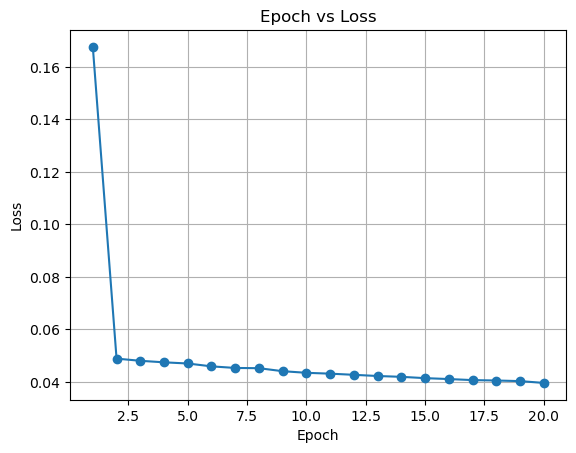

Validation Accuracy: 0.3468
Hamming Loss for validation: 0.0100
Test Accuracy: 0.3594
Hamming Loss for test: 0.0099


In [20]:
mlp_executive(20, [512, 256], "relu", "minibatchgd", 0.01, 64)

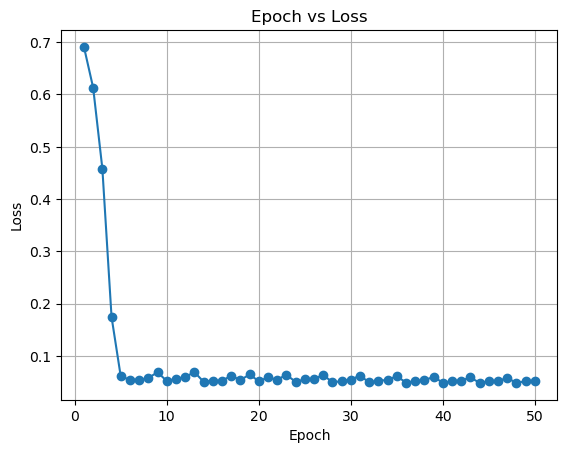

Validation Accuracy: 0.0026
Hamming Loss for validation: 0.0137
Test Accuracy: 0.0020
Hamming Loss for test: 0.0138


In [33]:
mlp_executive(50, [512, 256], "relu", "batchgd", 0.1, 64)

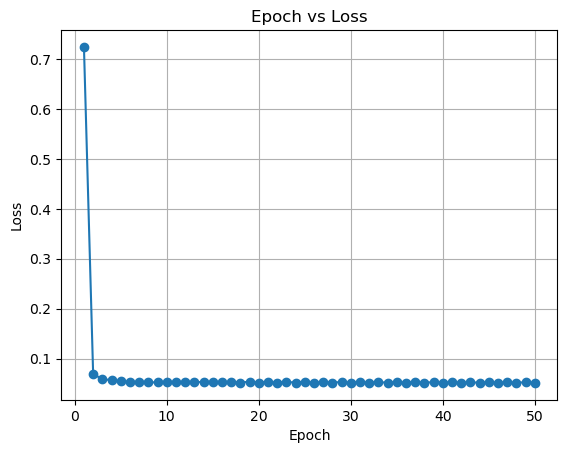

Validation Accuracy: 0.0000
Hamming Loss for validation: 0.0137
Test Accuracy: 0.0000
Hamming Loss for test: 0.0138


In [34]:
mlp_executive(50, [512, 256], "sigmoid", "batchgd", 0.1, 64)

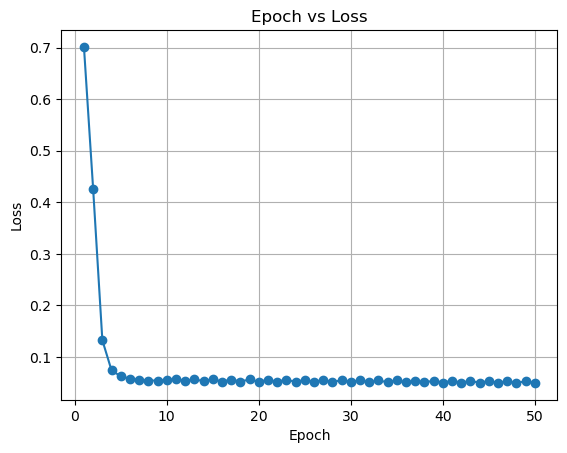

Validation Accuracy: 0.0019
Hamming Loss for validation: 0.0137
Test Accuracy: 0.0017
Hamming Loss for test: 0.0138


In [35]:
mlp_executive(50, [512, 256], "tanh", "batchgd", 0.1, 64)

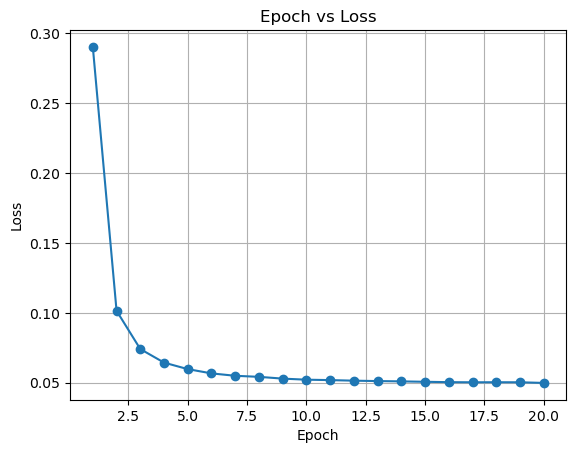

Validation Accuracy: 0.0000
Hamming Loss for validation: 0.0137
Test Accuracy: 0.0000
Hamming Loss for test: 0.0138


In [36]:
mlp_executive(20, [512, 256], "sigmoid", "minibatchgd", 0.001, 64)

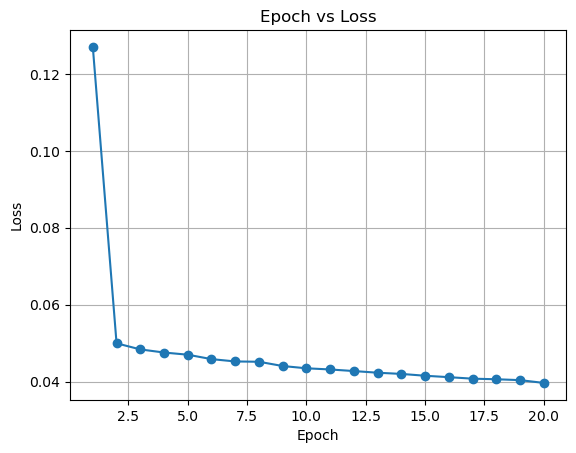

Validation Accuracy: 0.3430
Hamming Loss for validation: 0.0100
Test Accuracy: 0.3620
Hamming Loss for test: 0.0100


In [28]:
mlp_executive(20, [512, 256], "tanh", "minibatchgd", 0.01, 64)

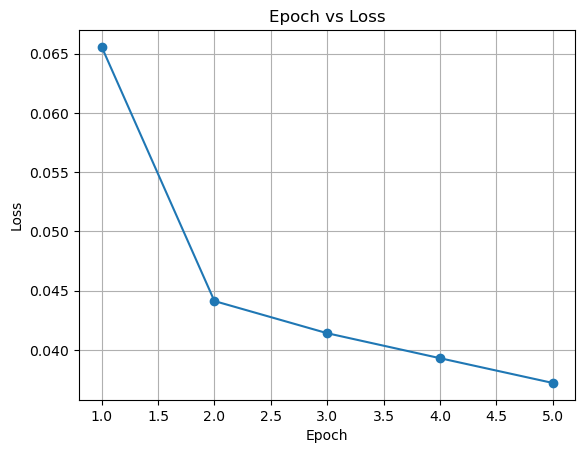

Validation Accuracy: 0.4241
Hamming Loss for validation: 0.0091
Test Accuracy: 0.4362
Hamming Loss for test: 0.0090


In [29]:
mlp_executive(5, [512, 256], "relu", "sgd", 0.001, 64)

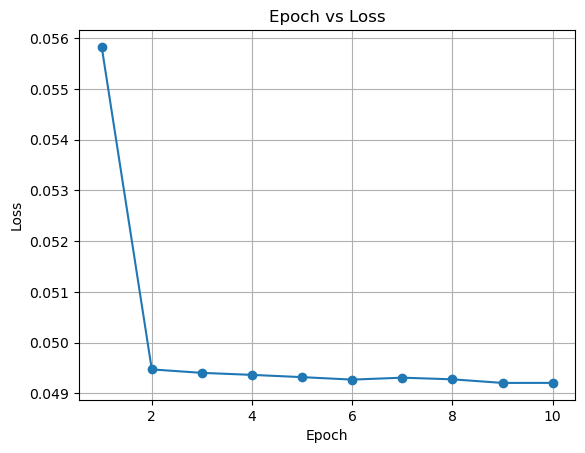

Validation Accuracy: 0.2207
Hamming Loss for validation: 0.0112
Test Accuracy: 0.2531
Hamming Loss for test: 0.0110


In [37]:
mlp_executive(10, [512, 256], "sigmoid", "sgd", 0.001, 64)

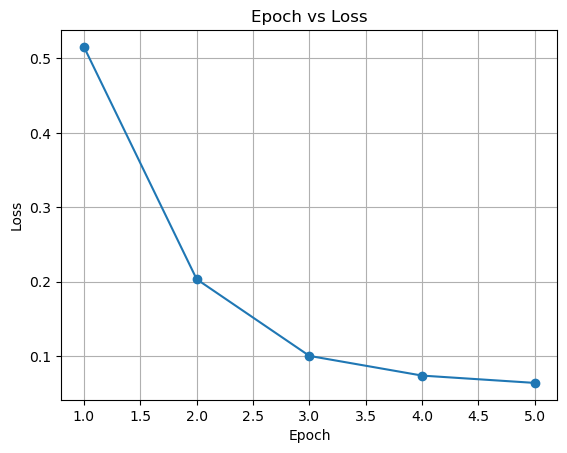

Validation Accuracy: 0.0019
Hamming Loss for validation: 0.0137
Test Accuracy: 0.0003
Hamming Loss for test: 0.0138


In [ ]:
mlp_executive(5, [512, 256], "tanh", "sgd", 0.001, 64)

Out of all combinations "SGD", "relu" performance is better, with accuracy value 0.4362 and after that, mini batch performed better with relu combination 0.3594

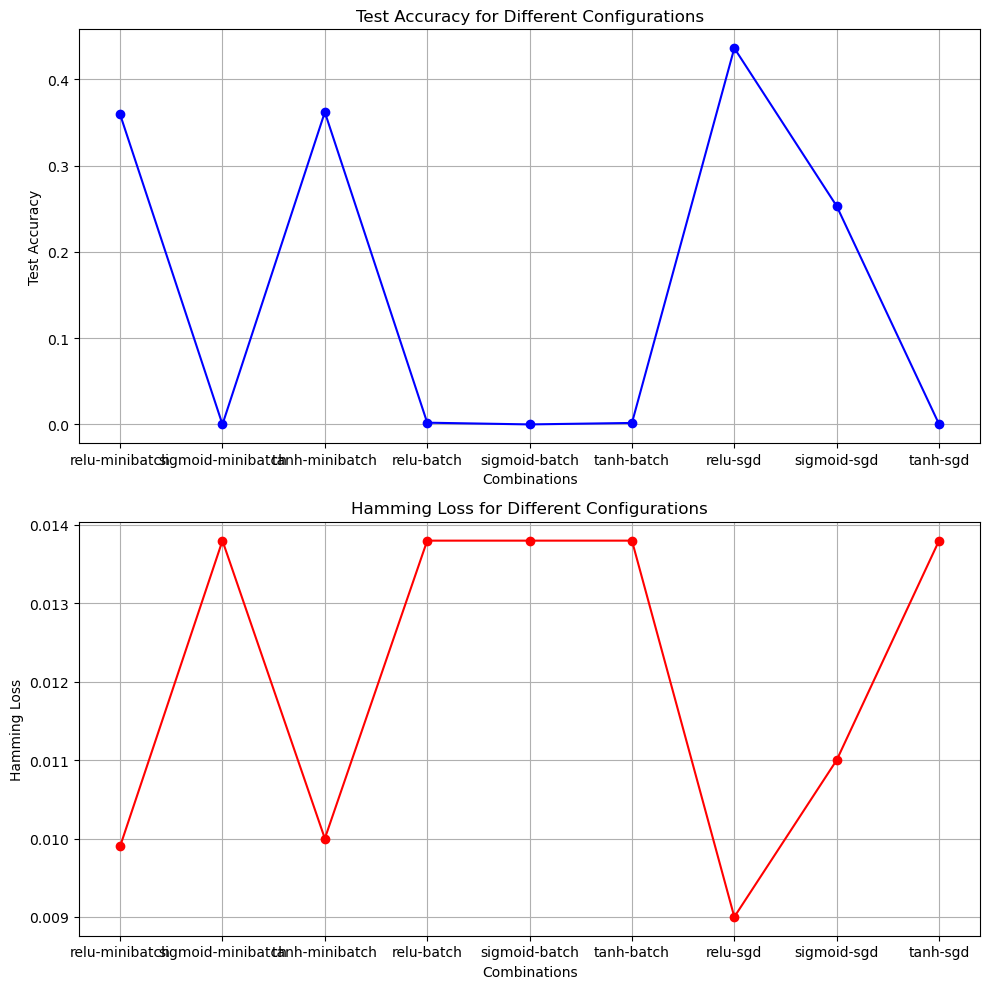

In [1]:
import matplotlib.pyplot as plt

# Data for the metrics
combinations = ['relu-minibatch', 'sigmoid-minibatch', 'tanh-minibatch', 
                'relu-batch', 'sigmoid-batch', 'tanh-batch', 
                'relu-sgd', 'sigmoid-sgd', 'tanh-sgd']

accuracy_values = [0.3594, 0.0000, 0.3620, 0.0020, 0.0000, 0.0017, 0.4362, 0.2531, 0.0003]
hamming_loss_values = [0.0099, 0.0138, 0.0100, 0.0138, 0.0138, 0.0138, 0.0090, 0.0110, 0.0138]

# Create subplots for each metric
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot Test Accuracy
ax1.plot(combinations, accuracy_values, marker='o', color='b', label='Test Accuracy')
ax1.set_title('Test Accuracy for Different Configurations')
ax1.set_xlabel('Combinations')
ax1.set_ylabel('Test Accuracy')
ax1.grid(True)

# Plot Hamming Loss
ax2.plot(combinations, hamming_loss_values, marker='o', color='r', label='Hamming Loss')
ax2.set_title('Hamming Loss for Different Configurations')
ax2.set_xlabel('Combinations')
ax2.set_ylabel('Hamming Loss')
ax2.grid(True)

# Display the plot
plt.tight_layout()
plt.show()
